**Problem Type:** Binary Classification

## Evaluation Metric


# XGBoost

This is based on a generic framework that I'm starting to develop.  Eventually, it will also support catboost, lgbm, and a Keras/TF DNN.

- https://www.kaggle.com/code/meetnagadia/titanic-random-forest-score-0-79471
- https://www.kaggle.com/code/adamml/my-spaceship-titanic-80-5



<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [1]:
import os
from pathlib import Path
import time
import gc

import random
import pandas as pd
import numpy as np
import datatable as dt  # Fast table loading

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder

# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import mode

# GBDTs
# from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")  # ggplot fivethirtyeight bmh
pd.options.display.max_columns = 500

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

In [3]:
class Config:
    path = "../input/spaceship-titanic"
    gpu = True
    debug = False
    optimize = False
    n_optimize_trials = 5
    model_type = "xgb"  # (xgb, cat, lgbm, keras)
    model_name = "xgb1"
    competition = "Spaceship Titanic"
    seed = 42
    N_ESTIMATORS = 100  # 100, 300, 2000, 5000

    batch_size = 64
    epochs = 25
    N_FOLDS = 10  # 5,10,15
    SEED_LENGTH = 1  # 5,10

In [4]:
TARGET = "Transported"
TARGET_ENC = "target_num"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Utilities</h1>
</div>

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    # train_df = dt.fread(data_dir / "train.csv").to_pandas()
    # test_df = dt.fread(data_dir / "test.csv").to_pandas()

    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [7]:
def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

In [8]:
# OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

In [9]:
def seed_everything(seed=Config.seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

Support datatable for large datasets.
Using datatable is described in [Tutorial on reading datasets](https://www.kaggle.com/hiro5299834/tutorial-on-reading-datasets)

In [10]:
%%time
train, test, submission_df = read_data(Config.path)

train data: Rows=8693, Columns=14
test data : Rows=4277, Columns=13
CPU times: user 37 ms, sys: 10.9 ms, total: 47.9 ms
Wall time: 73 ms


In [11]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [12]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

## Fix Missing Values

### KNN

In [13]:
from sklearn import impute


def knn_impute(X, test):
    knn_imputer = impute.KNNImputer(n_neighbors=2)
    knn_imputer.fit_transform(X)
    knn_imputer.transform(test)

    return X, test

### Misc Ideas

In [14]:
def fix_missing(train, test):
    Missing_features = [
        "FoodCourt",
        "Spa",
        "ShoppingMall",
        "RoomService",
        "VRDeck",
        "Cabin",
        "CryoSleep",
        "VIP",
        "HomePlanet",
        "Destination",
        "Age",
    ]
    for feature in Missing_features:
        if feature == "Age":
            fill = train[feature].mean()
        else:
            fill = train[feature].value_counts().index[0]
        train[feature] = train[feature].fillna(fill)
        test[feature] = test[feature].fillna(fill)
    return train, test

In [15]:
train = create_folds(train, TARGET, Config.N_FOLDS)

TARGET=Transported, n_folds=10, seed=42


In [16]:
train[TARGET_ENC] = train[TARGET].replace({True: 1, False: 0})
train[TARGET] = train[TARGET].replace({True: 1, False: 0})

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Feature Engineering</h1>
</div>

Feature creation is unique to each competition.

In [17]:
def create_features(df, train=True):

    return df

In [18]:
train["isTrain"] = True
test["isTrain"] = False

tt = pd.concat([train, test]).reset_index(drop=True).copy()

# tt = create_features(tt)

train = tt.query("isTrain").reset_index(drop=True).copy()
test = tt.query("isTrain == False").reset_index(drop=True).copy()

del tt
gc.collect()

2566

In [19]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,fold,target_num,isTrain
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,8.0,0.0,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,5.0,1.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,4.0,0.0,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,4.0,0.0,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,6.0,1.0,True


In [20]:
FEATURES = [
    col
    for col in train.columns
    if col
    not in [
        "PassengerId",
        "fold",
        TARGET,
        TARGET_ENC,
        "isTrain",
        #         "HomePlanet",
        #         "CryoSleep",
        "Cabin",
        #         "Destination",
        #         "VIP",
        "Name",
    ]
]

## Label Encode Categorical Features

In [21]:
label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]

train, test = label_encoder(train, test, label_cols)

In [22]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,fold,target_num,isTrain
0,0001_01,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,8.0,0.0,True
1,0002_01,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,5.0,1.0,True
2,0003_01,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,4.0,0.0,True
3,0003_02,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,4.0,0.0,True
4,0004_01,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,6.0,1.0,True


## One-Hot Encode


Good for low cardinality fields

- https://www.kaggle.com/code/dansbecker/using-categorical-data-with-one-hot-encoding/notebook
- [When to use One Hot Encoding vs LabelEncoder vs DictVectorizor?](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor)


## Impute

In [23]:
train = train.drop(["Name"], axis=1)
test = test.drop(["Name"], axis=1)

###  XGB Impute

In [24]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def xgb_impute(X, test):
    imp = IterativeImputer(
        estimator=xgb.XGBRegressor(
            n_estimators=120,
            random_state=42,
            tree_method="gpu_hist",
        ),
        missing_values=np.nan,
        max_iter=15,
        initial_strategy="mean",
        imputation_order="ascending",
        verbose=2,
        random_state=42,
    )

    X[:] = imp.fit_transform(X)
    test[:] = imp.transform(test)
    return X, test

- https://www.kaggle.com/code/hamzaghanmi/let-s-use-keras-tensorflow

### Mean, Median, Mode

In [25]:
def impute_data(train, test, columns, method):
    for col in columns:
        if method == "mean":
            value = train[col].mean()
            train[col].fillna(value, inplace=True)
            test[col].fillna(value, inplace=True)
        elif method == "mode":
            value = train[col].mode()[0]
            train[col].fillna(value, inplace=True)
            test[col].fillna(value, inplace=True)
        elif method == "median":
            value = train[col].median()
            train[col].fillna(value, inplace=True)
            test[col].fillna(value, inplace=True)
    return train, test

In [26]:
# train, test = fix_missing(train, test)
# train, test = knn_impute(train, test)
xgb_impute(train, test)

[IterativeImputer] Completing matrix with shape (8693, 16)
[IterativeImputer] Ending imputation round 1/15, elapsed time 7.82
[IterativeImputer] Change: 9836.248968584754, scaled tolerance: 928.0020000000001 
[IterativeImputer] Ending imputation round 2/15, elapsed time 13.13
[IterativeImputer] Change: 3347.613784790039, scaled tolerance: 928.0020000000001 
[IterativeImputer] Ending imputation round 3/15, elapsed time 19.09
[IterativeImputer] Change: 3357.4794921875, scaled tolerance: 928.0020000000001 
[IterativeImputer] Ending imputation round 4/15, elapsed time 24.38
[IterativeImputer] Change: 5624.36083984375, scaled tolerance: 928.0020000000001 
[IterativeImputer] Ending imputation round 5/15, elapsed time 29.82
[IterativeImputer] Change: 5224.01123046875, scaled tolerance: 928.0020000000001 
[IterativeImputer] Ending imputation round 6/15, elapsed time 35.11
[IterativeImputer] Change: 5061.7451171875, scaled tolerance: 928.0020000000001 
[IterativeImputer] Ending imputation round

(      PassengerId  HomePlanet  CryoSleep   Cabin  Destination   Age  VIP  \
 0           101.0         1.0        0.0   149.0          2.0  39.0  0.0   
 1           201.0         0.0        0.0  2184.0          2.0  24.0  0.0   
 2           301.0         1.0        0.0     1.0          2.0  58.0  1.0   
 3           302.0         1.0        0.0     1.0          2.0  33.0  0.0   
 4           401.0         0.0        0.0  2186.0          2.0  16.0  0.0   
 ...           ...         ...        ...     ...          ...   ...  ...   
 8688     927601.0         1.0        0.0   146.0          0.0  41.0  1.0   
 8689     927801.0         0.0        1.0  5280.0          1.0  18.0  0.0   
 8690     927901.0         0.0        0.0  5285.0          2.0  26.0  0.0   
 8691     928001.0         1.0        0.0  2131.0          0.0  32.0  0.0   
 8692     928002.0         1.0        0.0  2131.0          2.0  44.0  0.0   
 
       RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported  

In [27]:
# # impute categorical features
# train, test = impute_data(
#     train,
#     test,
#     columns=["HomePlanet", "CryoSleep", "Destination", "VIP"],
#     method="mode",
# )

# # impute numerical features
# train, test = impute_data(
#     train,
#     test,
#     columns=["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
#     method="mean",
# )

## Select Best Features

- p152 Another way of imputing missing values in a column would be to train a regression model that tries to predict missing values in a column based on other columns.
- p155 remove features with very low variance. If the features have a very low variance (i.e. very close to 0), they are close to being constant and thus, do not add any value to any model

## Optimize XGBoost

In [28]:
X = train[FEATURES].copy()
y = train[TARGET_ENC].astype(int)

print(X.shape)
print(y.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(8693, 10)
(8693,)


In [29]:
y_train.unique(), y_valid.unique()

(array([0, 1]), array([1, 0]))

In [30]:
def objective_xgb(trial, X_train, X_valid, y_train, y_valid):

    xgb_params = {
        #         "objective": trial.suggest_categorical("objective", ["multi:softmax"]),
        #         "eval_metric": "mlogloss",
        #         "objective": "multi:softmax",
        "eval_metric": "auc",  # auc, rmse, mae
        "objective": "binary:logistic",
        #         "enable_categorical": trial.suggest_categorical("use_label_encoder", [True]),
        "use_label_encoder": trial.suggest_categorical("use_label_encoder", [False]),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 0.25),
        "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.01),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 1, 20),  # 10
        "gamma": trial.suggest_float("gamma", 0, 100, step=0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "tree_method": trial.suggest_categorical(
            "tree_method", ["gpu_hist"]
        ),  # hist, gpu_hist
        "predictor": "gpu_predictor",
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 100),
        "random_state": trial.suggest_categorical("random_state", [42]),
        "n_jobs": trial.suggest_categorical("n_jobs", [4]),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1e-1, 1e3),
        # "min_child_weight": trial.suggest_categorical("min_child_weight", [256]),
    }

    # Model loading and training
    model = XGBClassifier(**xgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=5000,
        verbose=False,
    )

    print(f"Number of boosting rounds: {model.best_iteration}")
    #     oof = model.predict_proba(X_valid)[:, 1] # Probability
    oof = model.predict(X_valid)  # Classification: 0,1

    return accuracy_score(y_valid, oof)


#     return roc_auc_score(y_valid, oof)

In [31]:
time_limit = 3600 * 3

if Config.optimize and Config.model_type == "xgb":
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_xgb(trial, X_train, X_valid, y_train, y_valid),
        n_trials=Config.n_optimize_trials,  # 2, 10, 50, 100
        # timeout=time_limit,  # this or n_trials
    )

## Show Optimization Results

In [32]:
if Config.optimize:
    print("Number of finished trials:", len(study.trials))
    print("Best trial parameters:", study.best_trial.params)
    print("Best score:", study.best_value)

In [33]:
# Default

xgb_params = {
    "objective": "binary:logistic",
    #     "use_label_encoder": False,
    "enable_categorical": True,
    "n_estimators": Config.N_ESTIMATORS,
    # "eval_metric": "mlogloss",
    #     "eval_metric": "auc",
    "eval_metric": "accuracy",
    "learning_rate": 0.1,  # 0.9,0.1
    #     "learning_rate": 0.15525187869673937,
    #     "subsample": 0.66,
    #     "colsample_bytree": 0.9500000000000001,
    "subsample": 0.75,
    "colsample_bytree": 0.5,
    #     "max_depth": 4,
    #     "booster": "gbtree",
    #     "gamma": 1.7000000000000002,
    "tree_method": "hist",  # "gpu_hist", "hist"
    # "reg_lambda": 0.9541035898656812,
    #  "reg_alpha": 2.3445012085324084,
    "random_state": 42,
    "n_jobs": 4,
    #     "min_child_weight": 256,
}

if Config.gpu:
    xgb_params["tree_method"] = "gpu_hist"
else:
    xgb_params["tree_method"] = "hist"

In [34]:
# Optimized

xgb_params = {
    #     "use_label_encoder": False,
    "enable_categorical": True,
    "n_estimators": 1000,
    "learning_rate": 0.021138659045230178,
    "subsample": 0.4,
    "colsample_bytree": 0.91,
    "max_depth": 17,
    "gamma": 0.6000000000000001,
    "booster": "gbtree",
    "tree_method": "gpu_hist",
    "reg_lambda": 0.005882742898970815,
    "reg_alpha": 0.0014501578157205654,
    "random_state": 42,
    "n_jobs": 4,
    "min_child_weight": 5.567082153821453,
}

if Config.gpu:
    xgb_params["tree_method"] = "gpu_hist"
else:
    xgb_params["tree_method"] = "hist"

## Use Best Hyperparameters

In [35]:
if Config.optimize:
    xgb_params = study.best_trial.params

In [36]:
train[FEATURES].head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0


In [37]:
print(xgb_params)

{'enable_categorical': True, 'n_estimators': 1000, 'learning_rate': 0.021138659045230178, 'subsample': 0.4, 'colsample_bytree': 0.91, 'max_depth': 17, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'gpu_hist', 'reg_lambda': 0.005882742898970815, 'reg_alpha': 0.0014501578157205654, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 5.567082153821453}


In [38]:
def train_xgb_model(df, test, FEATURES, TARGET, params, n_folds=5, seed=42):
    print(params)
    final_test_predictions = []
    final_valid_predictions = {}
    fold_scores = []  # Scores of Validation Set
    feature_importance_lst = []

    test = test[FEATURES].copy()

    # oof_preds = np.zeros((df.shape[0],)) # Zero array
    # print(f"oof_preds size={df.shape[0]}")
    print(
        f"\n===== XGBoost Estimators: {params['n_estimators']}, Random State: {seed} ====="
    )

    for fold in range(n_folds):
        print(10 * "=", f"Fold {fold+1}/{n_folds}", 10 * "=")

        start_time = time.time()

        xtrain = df[df.fold != fold].reset_index(
            drop=True
        )  # Everything not in validation fold
        xvalid = df[df.fold == fold].reset_index(drop=True)
        xtest = test.copy()

        valid_ids = (
            xvalid.PassengerId.values.tolist()
        )  # Id's of everything in validation fold

        ytrain = xtrain[TARGET]
        yvalid = xvalid[TARGET]

        xtrain = xtrain[FEATURES]
        xvalid = xvalid[FEATURES]

        model = xgb.XGBClassifier(**params)

        model.fit(
            xtrain,
            ytrain,
            eval_set=[(xvalid, yvalid)],
            verbose=False,
            early_stopping_rounds=3000,
        )

        # Mean of the predictions
        preds_valid = model.predict(xvalid)
        test_preds = model.predict(xtest)

        #         preds_valid = model.predict_proba(xvalid)[:, 1]
        #         test_preds = model.predict_proba(xtest)[:, 1]

        final_test_predictions.append(test_preds)
        final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))

        fold_score = accuracy_score(yvalid, preds_valid)  # Validation Set Score
        #         fold_score = roc_auc_score(yvalid, preds_valid)  # Validation Set Score

        fold_scores.append(fold_score)

        # Feature importance
        fi = pd.DataFrame(
            index=FEATURES,
            data=model.feature_importances_,
            columns=[f"{fold}_importance"],
        )
        feature_importance_lst.append(fi)

        run_time = time.time() - start_time

        print(f"fold: {fold+1}, Score: {fold_score}, Run Time: {run_time:.2f}")

    return (
        model,
        feature_importance_lst,
        fold_scores,
        final_valid_predictions,
        final_test_predictions,
    )

In [39]:
(
    model,
    feature_importance_lst,
    fold_scores,
    final_valid_predictions,
    final_test_predictions,
) = train_xgb_model(
    train, test, FEATURES, TARGET_ENC, xgb_params, Config.N_FOLDS, Config.seed
)

{'enable_categorical': True, 'n_estimators': 1000, 'learning_rate': 0.021138659045230178, 'subsample': 0.4, 'colsample_bytree': 0.91, 'max_depth': 17, 'gamma': 0.6000000000000001, 'booster': 'gbtree', 'tree_method': 'gpu_hist', 'reg_lambda': 0.005882742898970815, 'reg_alpha': 0.0014501578157205654, 'random_state': 42, 'n_jobs': 4, 'min_child_weight': 5.567082153821453}

===== XGBoost Estimators: 1000, Random State: 42 =====
========== Fold 1/10 ==========
fold: 1, Score: 0.7977011494252874, Run Time: 4.26
========== Fold 2/10 ==========
fold: 2, Score: 0.828735632183908, Run Time: 4.41
========== Fold 3/10 ==========
fold: 3, Score: 0.8172413793103448, Run Time: 4.29
========== Fold 4/10 ==========
fold: 4, Score: 0.7882623705408516, Run Time: 4.31
========== Fold 5/10 ==========
fold: 5, Score: 0.8147295742232451, Run Time: 4.39
========== Fold 6/10 ==========
fold: 6, Score: 0.8009205983889528, Run Time: 4.34
========== Fold 7/10 ==========
fold: 7, Score: 0.7974683544303798, Run Tim

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Scores</h1>
</div>

In [40]:
fold_scores

[0.7977011494252874,
 0.828735632183908,
 0.8172413793103448,
 0.7882623705408516,
 0.8147295742232451,
 0.8009205983889528,
 0.7974683544303798,
 0.807825086306099,
 0.7940161104718066,
 0.7905638665132336]

In [41]:
cv_score = np.mean(fold_scores)  # Used in filename
print(f"scores -> mean: {cv_score:0.6f}, std: {np.std(fold_scores):0.6f}")

scores -> mean: 0.803746, std: 0.012394


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Model Feature Importance</h1>
</div>

- [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)

In [42]:
fis_df = pd.concat(feature_importance_lst, axis=1)
fis_df.sort_values("0_importance", ascending=False).head(10)

,0_importance,1_importance,2_importance,3_importance,4_importance,5_importance,6_importance,7_importance,8_importance,9_importance
CryoSleep,0.311249,0.300162,0.303316,0.294112,0.293425,0.312220,0.285622,0.303082,0.302762,0.306045
HomePlanet,0.100807,0.101934,0.106802,0.102761,0.105425,0.101690,0.106338,0.101760,0.104425,0.102993
Spa,0.098082,0.098164,0.097997,0.097176,0.095931,0.099271,0.101114,0.097845,0.095000,0.098127
VRDeck,0.094234,0.093495,0.092652,0.095042,0.099312,0.090660,0.096831,0.094077,0.095223,0.095105
RoomService,0.092776,0.095685,0.092640,0.091744,0.093423,0.089486,0.094463,0.092745,0.092840,0.092582
FoodCourt,0.080651,0.082309,0.082539,0.084710,0.084992,0.081808,0.084470,0.082552,0.081746,0.080121
ShoppingMall,0.072985,0.075048,0.073987,0.078232,0.074802,0.071910,0.074896,0.073106,0.072655,0.073137
Age,0.058216,0.059508,0.059536,0.058324,0.059899,0.059615,0.060926,0.060621,0.059190,0.059459
VIP,0.045672,0.047294,0.044799,0.050881,0.047126,0.047061,0.048552,0.046872,0.050009,0.047759
Destination,0.045327,0.046400,0.045733,0.047018,0.045666,0.046279,0.046787,0.047340,0.046151,0.044672


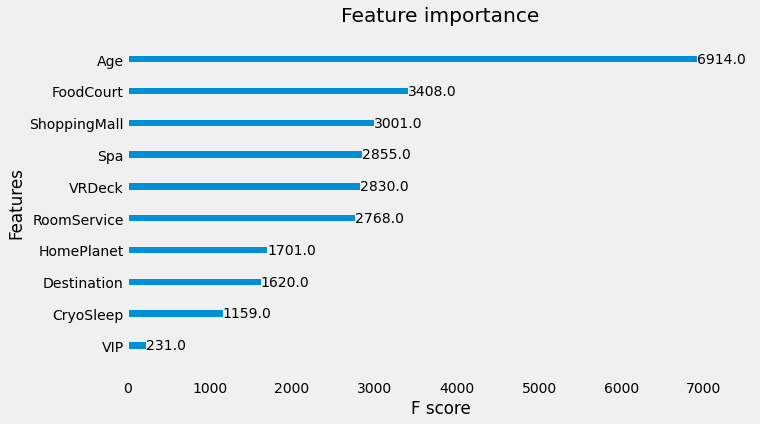

In [43]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, max_num_features=20, ax=ax, grid=False)
plt.show()

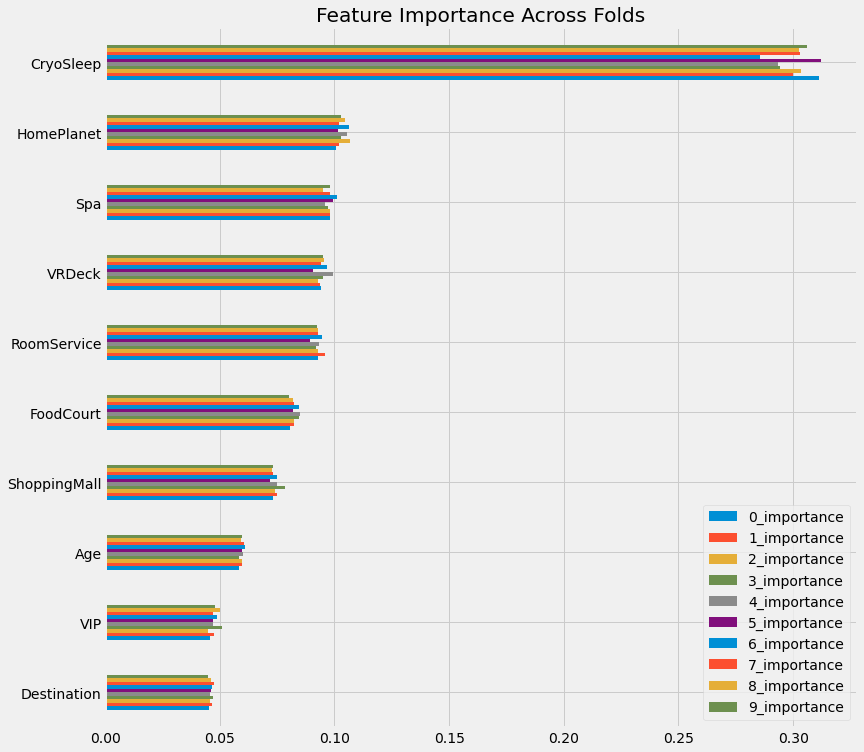

In [44]:
fis_df.sort_values("0_importance", ascending=True).tail(20).plot(
    kind="barh", figsize=(12, 12), title="Feature Importance Across Folds"
)
plt.show()

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Save OOF Predictions</h1>



In [45]:
pred_field = f"pred_{Config.model_name}"

final_valid_predictions_df = pd.DataFrame.from_dict(
    final_valid_predictions, orient="index"
).reset_index()

final_valid_predictions_df.columns = ["id", pred_field]

final_valid_predictions_df[pred_field] = final_valid_predictions_df[pred_field]

final_valid_predictions_df.to_csv(
    f"results/oof_preds_cv{cv_score:0.6f}_s{Config.seed}_k{Config.N_FOLDS}_{Config.model_name}.csv",
)

final_valid_predictions_df.head()

,id,pred_xgb1
0,701.0,0
1,5001.0,0
2,5201.0,0
3,6201.0,0
4,8601.0,0


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Submission</h1>
</div>

In [46]:
np.column_stack(final_test_predictions)

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [47]:
mode_result = mode(np.column_stack(final_test_predictions), axis=1)
result = mode_result[0].ravel()
result

array([1, 0, 1, ..., 1, 1, 1])

In [48]:
# mean_result = np.mean(np.column_stack(final_test_predictions), axis=1)  # .astype("int")

In [49]:
message = f"{Config.model_name}_cv{cv_score:0.6f}_seed{Config.seed}_k{Config.N_FOLDS}_n{Config.N_ESTIMATORS}"
print(f"\nSubmit Message: {message}\n")

submission_df[TARGET] = result  # mean_result.astype("bool")

submission_df.to_csv(
    f"results/test_preds_cv:{cv_score:0.6f}_s:{Config.seed}_k:{Config.N_FOLDS}_{Config.model_name}.csv",
    index=False,
)
submission_df.to_csv("submission.csv", index=False)
submission_df


Submit Message: xgb1_cv0.803746_seed42_k10_n100



,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,1
